## Intro to Domino Project

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 5, using Jupyter to load, explore, and transform some data. After the data has been prepared, we will train a model.

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

In [1]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

In [2]:
#read in our data
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,FUELHH,20191008,1,3461,0,0,6756,9780,0,372,...,72,846,90,102,504,1438,0,0,0,0
1,FUELHH,20191008,2,3460,0,0,6760,9628,0,377,...,72,844,90,102,504,1119,0,0,0,0
2,FUELHH,20191008,3,3484,0,0,6759,9500,0,377,...,72,734,90,102,504,1034,0,0,0,0
3,FUELHH,20191008,4,3569,0,0,6756,9369,0,377,...,72,742,90,102,504,1266,0,0,0,0
4,FUELHH,20191008,5,3505,0,0,6761,9250,0,377,...,72,252,90,102,504,1613,0,0,0,0


In [4]:
#rename the columns
df = df.iloc[:,0:18]
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,20191008,1,3461,0,0,6756,9780,0,372,0,72,846,90,102,504,1438,0
1,FUELHH,20191008,2,3460,0,0,6760,9628,0,377,0,72,844,90,102,504,1119,0
2,FUELHH,20191008,3,3484,0,0,6759,9500,0,377,0,72,734,90,102,504,1034,0
3,FUELHH,20191008,4,3569,0,0,6756,9369,0,377,0,72,742,90,102,504,1266,0
4,FUELHH,20191008,5,3505,0,0,6761,9250,0,377,0,72,252,90,102,504,1613,0


In [5]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

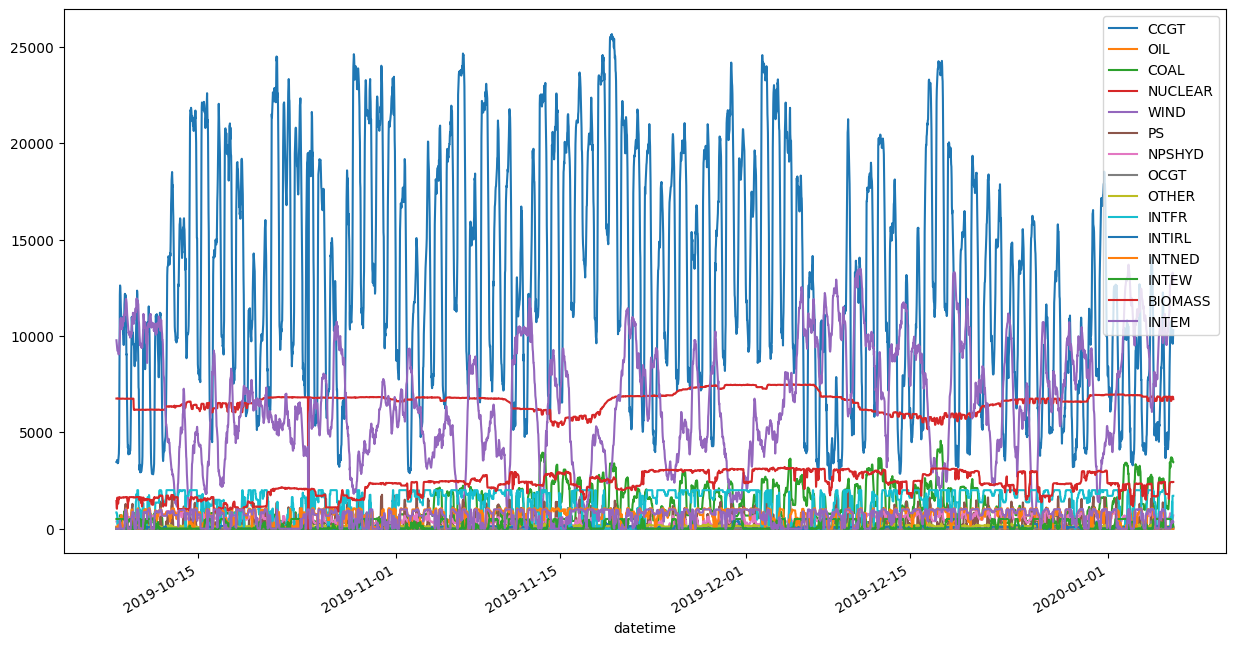

In [6]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [7]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})

In [8]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [9]:
#mport Facebook Prophet and fit a model
from prophet import Prophet

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

09:31:20 - cmdstanpy - INFO - Chain [1] start processing
09:31:20 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
#Make a DataFrame to hold the predictions and predict future values of CCGT power generation

future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3909,2020-01-06 10:00:00,14960.361590,9283.060566,20398.756463
3910,2020-01-06 11:00:00,14580.949583,8945.262382,19731.174701
3911,2020-01-06 12:00:00,14490.559377,8863.955033,19855.666523
3912,2020-01-06 13:00:00,14880.119255,8934.726007,20214.221005
3913,2020-01-06 14:00:00,15474.668077,9683.736000,20916.399258


<Figure size 640x480 with 0 Axes>

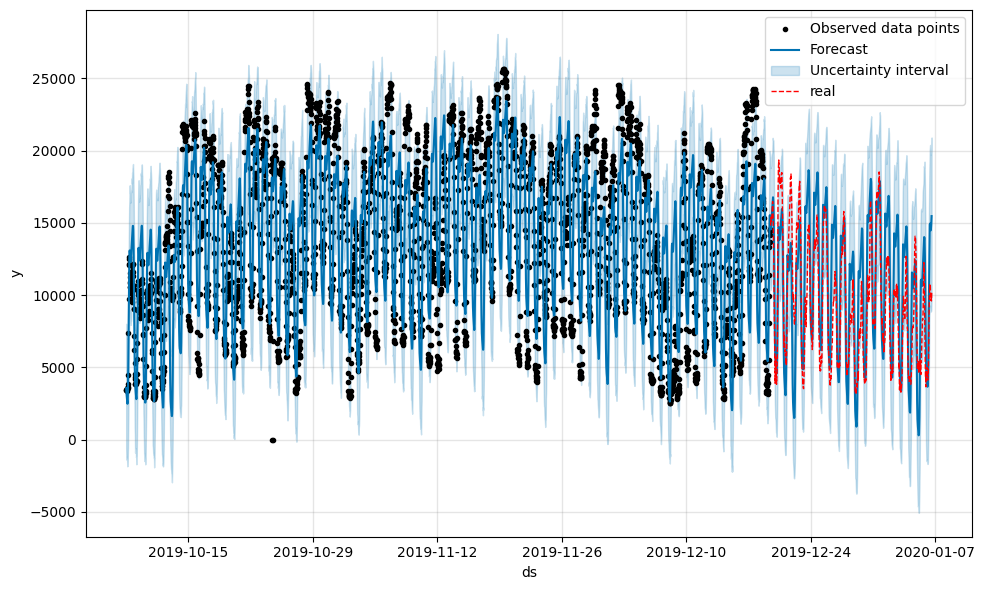

In [11]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [12]:
#export the trained model as a pickle file for later use
import pickle
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("/mnt/artifacts/model.pkl", "wb") as f:
      pickle.dump(m, f)